# First model (paper: flower classification via CNN) 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras import regularizers
import pathlib
#import splitfolders
import scipy.io
import pandas as pd
import shutil
import glob


from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D
from tensorflow.keras import regularizers
from pathlib import Path
from tensorflow import keras
from livelossplot.inputs.keras import PlotLossesCallback
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pickle

# set up data

In [2]:
dataset_train ="train"
train_dir = pathlib.Path(dataset_train)

In [3]:
train_dir

WindowsPath('train')

In [4]:
data_image = list(train_dir.glob('*/*.jpg'))
image_count = len(data_image)
print(image_count)

6005


In [5]:
batch_size = 100
img_height = 100
img_width = 100

# work on train dataset

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory="train",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6005 files belonging to 102 classes.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  
    directory="val", 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1019 files belonging to 102 classes.


In [8]:
class_names = train_ds.class_names

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(100, 100, 100, 3)
(100,)


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
num_classes = 102

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 5 , padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3, 3)),
    
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3, 3)),
    
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3, 3)),
    
  layers.Conv2D(512, 3, padding='same', activation='relu'), 
  layers.Conv2D(512, 3, padding='same', activation='relu'),   
  layers.MaxPooling2D(pool_size=(3, 3)),
    
    
  
  layers.Flatten(),
  #layers.Dense(4096, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
  #layers.Dropout(0.5),
  layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Dense(num_classes,kernel_regularizer=regularizers.l2(0.001))
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)         0

In [13]:
plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='normal1.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

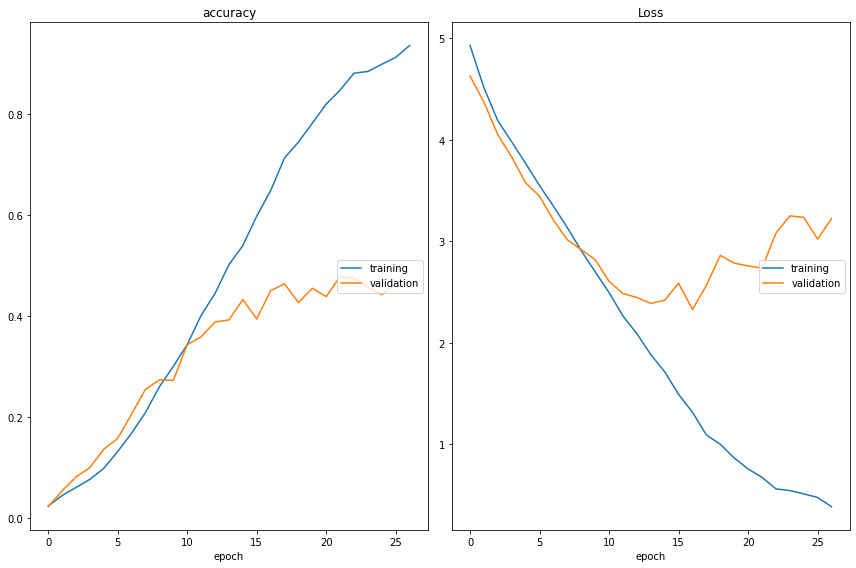

accuracy
	training         	 (min:    0.024, max:    0.936, cur:    0.936)
	validation       	 (min:    0.023, max:    0.479, cur:    0.469)
Loss
	training         	 (min:    0.385, max:    4.930, cur:    0.385)
	validation       	 (min:    2.328, max:    4.628, cur:    3.225)
61/61 [==============================] - 6s 97ms/step - loss: 0.3849 - accuracy: 0.9362 - val_loss: 3.2247 - val_accuracy: 0.4691


In [15]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
)

# testing + evaluation

In [16]:
dataset_test ="test"
test_dir = pathlib.Path(dataset_test)

In [17]:
data1_image = list(test_dir.glob('*/*.jpg'))
image1_count = len(data1_image)
print(image1_count)

1165


In [18]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory="test", 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1165 files belonging to 102 classes.


In [19]:
results = model.evaluate(test_ds)

12/12 [==============================] - 1s 98ms/step - loss: 2.3262 - accuracy: 0.4558


In [20]:
results

[2.3261828422546387, 0.45579397678375244]

In [21]:
test_data_image = list(test_dir.glob('*/*.jpg'))


x = []
for img_path in test_data_image:
    img = keras.preprocessing.image.load_img( img_path, target_size=(img_height, img_width) )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array)
    score = tf.nn.softmax(prediction[0])
    print(class_names[np.argmax(score)], " with ", 100 * np.max(score))
    x.append(score)

# Summary

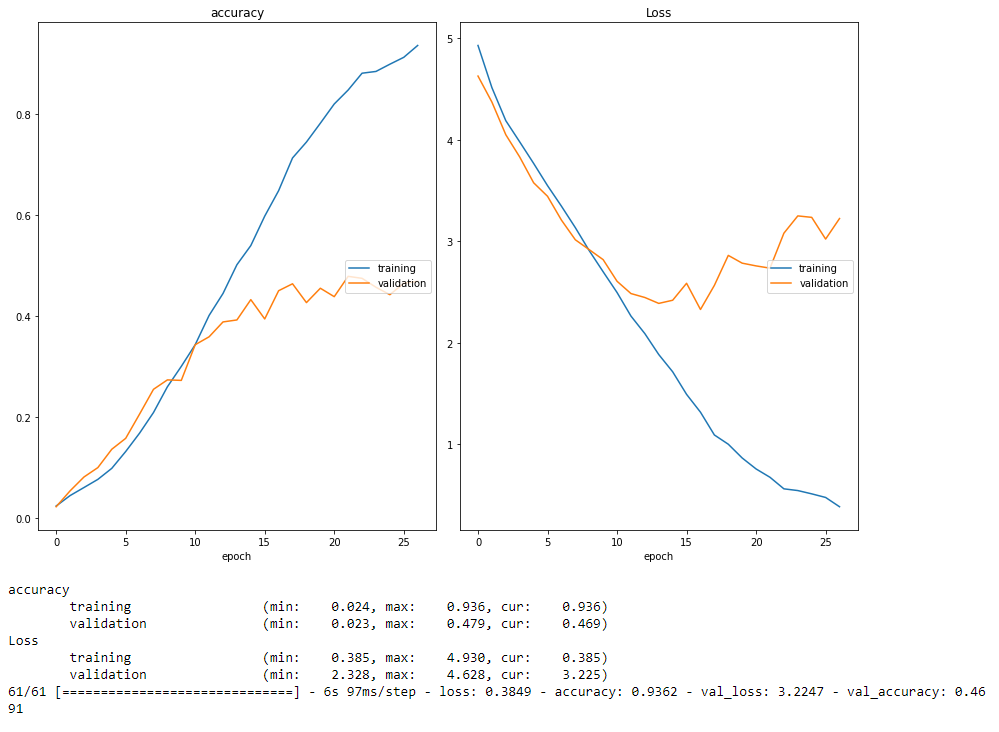
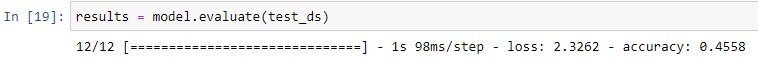